# Customer Segmentation & Recency, Frequency, Monetary Modeling & Upselling

We discovered some interesting observations around our cohort data set. While cohort analysis provides us with customer behavior overtime and understand retention rates, we also want to be able to segment our data by their behavior as well.

In [1]:
import pandas as pd # for dataframes
import numpy as np
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import re
from pandas.plotting import scatter_matrix
from datetime import datetime
import plotly.offline as py
import plotly.graph_objs as go


In [2]:
myData= pd.read_csv('../dataSource.csv')
myData

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,...,customer_city,customer_state,customer_unique_id,review_response_time,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,9/19/2017 9:45,58.9,13.29,1,Credit Card,2,...,Campos Dos Goytacazes,RJ,5ee8fe956c2631afc0a1dcc1920d0e3d,1,2017,9,2,8,Wed,Sep
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,7/5/2017 2:44,55.9,17.96,1,Boleto,1,...,Jatai,GO,8b3f917f4307d3e5cf34c0b43d6e6f50,3,2017,6,2,11,Wed,Jun
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,5/23/2018 10:56,64.9,18.33,1,Credit Card,2,...,Belo Horizonte,MG,69ba88e17ea574da9c9b8c8834a583d1,1,2018,5,4,10,Fri,May
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,8/7/2017 18:55,58.9,16.17,1,Credit Card,3,...,Sao Jose Dos Pinhais,PR,cbe063493a222cb17024ff0285b4ecb6,3,2017,8,1,18,Tue,Aug
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,8/16/2017 22:05,58.9,13.29,1,Credit Card,4,...,Conselheiro Lafaiete,MG,ffab5330bd7b40979ab6726b2e02292e,3,2017,8,3,21,Thu,Aug
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116576,fdaf98feac227eb978d8f33f36e0231d,1,f739e9151702508b18f796c53005e5e9,d1aa1ec0839dcab73a6161130eb1f94a,4/27/2017 5:10,119.9,16.14,1,Boleto,1,...,Rio De Janeiro,RJ,e060eb8f37de232154b24bbb2413b68e,1,2017,4,2,10,Wed,Apr
116577,fe68b52db13993f58175fa589125d345,1,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,8/17/2017 2:55,209.0,16.21,1,Boleto,1,...,Limeira,SP,3041f5d65c4fa516eed1325d7a8657af,1,2017,8,4,10,Fri,Aug
116578,fefacc66af859508bf1a7934eab1e97f,1,69c590f7ffc7bf8db97190b6cb6ed62e,80ceebb4ee9b31afb6c6a916a574a1e2,8/2/2018 4:05,6729.0,193.21,1,Boleto,1,...,Vitoria,ES,57b628f46c00f9a7358e5e875d5b4dd0,0,2018,7,2,18,Wed,Jul
116579,ff701a7c869ad21de22a6994237c8a00,1,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,4/18/2018 20:10,27.9,14.44,1,Credit Card,1,...,Cacapava,SP,ea4d52b176423e61a84052b0f4717be9,3,2018,4,3,19,Thu,Apr


In [5]:
features = ['order_id', 'order_status', 'order_purchase_timestamp',
       'payment_value', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state']
myData_db = myData[features].copy()


In [6]:
#chuyển cột order_purchase_timestamp từ dạng string thành dạng date
myData_db['order_purchase_date'] = pd.to_datetime(myData_db.order_purchase_timestamp, format="%m/%d/%Y %H:%M").dt.date
myData_db['order_purchase_date'] = pd.to_datetime(myData_db['order_purchase_date'])
myData_db['order_purchase_date']


0        2017-09-13
1        2017-06-28
2        2018-05-18
3        2017-08-01
4        2017-08-10
            ...    
116576   2017-04-19
116577   2017-08-11
116578   2018-07-25
116579   2018-04-12
116580   2018-04-12
Name: order_purchase_date, Length: 116581, dtype: datetime64[ns]

In [8]:
myData_db = myData_db.drop_duplicates()
delivered = myData_db.loc[myData_db["order_status"] == "delivered"]

### Function to describe customer orders 

In [9]:

def clustering_customers(df, date_max, date_min=False, group_range_days=False):
    df = df.copy()

    if(date_min == False):
        cond_f = df["order_purchase_date"] <= pd.to_datetime(date_max)
    else:
        cond_1 = df["order_purchase_date"] <= pd.to_datetime(date_max)
        cond_2 = df["order_purchase_date"] >= pd.to_datetime(date_min)
        cond_f = cond_1 & cond_2

    df = df.loc[cond_f]

    df["today"] = df["order_purchase_date"].max()

    # df["today"] = df["today"].dt.date
    # df["today"] = pd.to_datetime(df["today"], format="%Y-%m-%d")

    df["order_purchase_days_since"] = df["today"]  - df["order_purchase_date"]
    df["order_purchase_days_since"] = df["order_purchase_days_since"].astype(str)
    df["order_purchase_days_since"] = df["order_purchase_days_since"].str.replace(r' days.*', '', regex=True)
    df["order_purchase_days_since"] = df["order_purchase_days_since"].astype(int)
    df["order_purchase_year"] = df["order_purchase_date"].dt.year

   
    df_group = df.groupby(["customer_unique_id"]).agg({
        "order_purchase_days_since": ["min", "max", "count"],
        "payment_value": ["sum","mean"]
    }).reset_index()

    df_group.columns = [' '.join(col).strip() for col in df_group.columns.values]

    
    df_group.rename({
        "order_purchase_days_since max": "first_order_purchase",
        "order_purchase_days_since min": "last_order_purchase",
        "order_purchase_days_since count": "order_purchase_qty",
        "payment_value mean": "payment_value_mean",
        "payment_value sum": "payment_value_sum"
    }, axis=1, inplace=True)

    median_payment = df_group["payment_value_mean"].median()

    if(group_range_days == False):
        major_group = 4
        range_days = str(df["order_purchase_date"].max() - df["order_purchase_date"].min()) 
        group_range_days = int(re.sub(r'\s+days.*', '', range_days))/major_group

    cond_payment_zero = df_group['payment_value_mean'] == 0.0
    #nếu   df_group['last_order_purchase'] càng lớn -> lần mua đầu tiên cách càng xa
    cond_inactive_1 = df_group['last_order_purchase'] > group_range_days*3

    cond_inactive = cond_inactive_1 | cond_payment_zero

    cond_cold_1 = df_group['last_order_purchase'] > group_range_days*2
    cond_cold_2 = df_group['last_order_purchase'] <= group_range_days*3
    cond_cold = cond_cold_1 & cond_cold_2 & ~(cond_payment_zero)

    cond_hot_1 = df_group['last_order_purchase'] > group_range_days
    cond_hot_2 = df_group['last_order_purchase'] <= group_range_days*2
    cond_hot = cond_hot_1 & cond_hot_2 & ~(cond_payment_zero)

    cond_active_1 = df_group['last_order_purchase'] <= group_range_days
    cond_active = cond_active_1 & ~(cond_payment_zero)

    df_group.loc[cond_inactive, "segment"] = "inactive"
    df_group.loc[cond_cold, "segment"] = "cold"
    df_group.loc[cond_hot, "segment"] = "hot"
    df_group.loc[cond_active, "segment"] = "active"
    
    cond_hot_high_payment_1 = df_group["segment"] == "hot"
    cond_hot_high_payment_2 = df_group["payment_value_mean"] >= median_payment
    cond_hot_high_payment = cond_hot_high_payment_1 & cond_hot_high_payment_2
    
    cond_hot_low_payment_1 = df_group["segment"] == "hot"
    cond_hot_low_payment_2 = df_group["payment_value_mean"] < median_payment
    cond_hot_low_payment = cond_hot_low_payment_1 & cond_hot_low_payment_2
    
    cond_active_high_payment_1 = df_group["segment"] == "active"
    cond_active_high_payment_2 = df_group["payment_value_mean"] >= median_payment
    cond_active_high_payment = cond_active_high_payment_1 & cond_active_high_payment_2

    cond_active_low_payment_1 = df_group["segment"] == "active"
    cond_active_low_payment_2 = df_group["payment_value_mean"] < median_payment
    cond_active_low_payment = cond_active_low_payment_1 & cond_active_low_payment_2

    cond_cold_high_payment_1 = df_group["segment"] == "cold"
    cond_cold_high_payment_2 = df_group["payment_value_mean"] >= median_payment
    cond_cold_high_payment = cond_cold_high_payment_1 & cond_cold_high_payment_2

    cond_cold_low_payment_1 = df_group["segment"] == "cold"
    cond_cold_low_payment_2 = df_group["payment_value_mean"] < median_payment
    cond_cold_low_payment = cond_cold_low_payment_1 & cond_cold_low_payment_2

    df_group["sub_segment"] = "inactive"
    df_group.loc[cond_hot_high_payment, "sub_segment"] = "hot_high_payment_value"
    df_group.loc[cond_hot_low_payment, "sub_segment"] = "hot_low_payment_value"
    df_group.loc[cond_active_high_payment, "sub_segment"] = "active_high_payment_value"
    df_group.loc[cond_active_low_payment, "sub_segment"] = "active_low_payment_value"
    df_group.loc[cond_cold_high_payment, "sub_segment"] = "cold_high_payment_value"
    df_group.loc[cond_cold_low_payment, "sub_segment"] = "cold_low_payment_value"

    cond_new_customer = df_group["first_order_purchase"] <= group_range_days*2
    df_group["new_customer"] = 0
    df_group.loc[cond_new_customer, "new_customer"] = 1
    
    return group_range_days, df_group


In [10]:
# customer payment purchase and orders until 2018
period_2018, df_clustering_2018 = clustering_customers(myData_db, "2018-12-31")
df_clustering_2018.head(5)

,customer_unique_id,last_order_purchase,first_order_purchase,order_purchase_qty,payment_value_sum,payment_value_mean,segment,sub_segment,new_customer
0,0000b849f77a49e4a4ce2b2a4ca5be3f,174,285,2,136.26,68.130000,active,active_low_payment_value,1
1,0000f46a3911fa3c0805444483337064,130,398,3,583.87,194.623333,active,active_high_payment_value,0
2,0004bd2a26a76fe21f786e4fbd80607f,12,455,4,480.54,120.135000,active,active_high_payment_value,0
3,00050ab1314c0e55a6ca13cf7181fecf,224,224,1,80.18,80.180000,hot,hot_low_payment_value,1
4,0005ef4cd20d2893f0d9fbd94d3c0d97,486,486,1,187.91,187.910000,cold,cold_high_payment_value,0


In [12]:
df_revenue_subsegment_2018 = df_clustering_2018.groupby(["sub_segment"]).agg({"payment_value_sum": "sum"}).reset_index()
df_revenue_subsegment_2018 = df_revenue_subsegment_2018.sort_values(by ='payment_value_sum', ascending= False)
print(df_revenue_subsegment_2018)
# configure_plotly_browser_state()
trace0 = go.Bar(
    x=df_revenue_subsegment_2018["sub_segment"].values,
    y=df_revenue_subsegment_2018["payment_value_sum"].values,
    marker=dict(
        color=['rgba(36,123,160,1)', 
               'rgba(75,147,177,1)',
               'rgba(112,193,179,1)', 
               'rgba(138,204,192,1)',
               'rgba(243,255,189,1)',
               'rgba(247,255,213,1)',
               'rgba(255,22,84,1)']),
)

data = [trace0]

layout = go.Layout(
    title='Revenue 2018 by Customer Group',
    
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

                 sub_segment  payment_value_sum
0  active_high_payment_value         8602975.35
1   active_low_payment_value         2811777.86
4     hot_high_payment_value         2575126.40
5      hot_low_payment_value          855437.90
2    cold_high_payment_value          522834.74
3     cold_low_payment_value          181146.07
6                   inactive           72387.51


ValueError: 
    Invalid value of type 'builtins.str' received for the 'xaxis' property of layout
        Received value: 'kjfahd'

    The 'xaxis' property is an instance of XAxis
    that may be specified as:
      - An instance of :class:`plotly.graph_objs.layout.XAxis`
      - A dict of string/value properties that will be passed
        to the XAxis constructor

        Supported dict properties:
            
            anchor
                If set to an opposite-letter axis id (e.g.
                `x2`, `y`), this axis is bound to the
                corresponding opposite-letter axis. If set to
                "free", this axis' position is determined by
                `position`.
            automargin
                Determines whether long tick labels
                automatically grow the figure margins.
            autorange
                Determines whether or not the range of this
                axis is computed in relation to the input data.
                See `rangemode` for more info. If `range` is
                provided, then `autorange` is set to False.
            autotypenumbers
                Using "strict" a numeric string in trace data
                is not converted to a number. Using *convert
                types* a numeric string in trace data may be
                treated as a number during automatic axis
                `type` detection. Defaults to
                layout.autotypenumbers.
            calendar
                Sets the calendar system to use for `range` and
                `tick0` if this is a date axis. This does not
                set the calendar for interpreting data on this
                axis, that's specified in the trace or via the
                global `layout.calendar`
            categoryarray
                Sets the order in which categories on this axis
                appear. Only has an effect if `categoryorder`
                is set to "array". Used with `categoryorder`.
            categoryarraysrc
                Sets the source reference on Chart Studio Cloud
                for `categoryarray`.
            categoryorder
                Specifies the ordering logic for the case of
                categorical variables. By default, plotly uses
                "trace", which specifies the order that is
                present in the data supplied. Set
                `categoryorder` to *category ascending* or
                *category descending* if order should be
                determined by the alphanumerical order of the
                category names. Set `categoryorder` to "array"
                to derive the ordering from the attribute
                `categoryarray`. If a category is not found in
                the `categoryarray` array, the sorting behavior
                for that attribute will be identical to the
                "trace" mode. The unspecified categories will
                follow the categories in `categoryarray`. Set
                `categoryorder` to *total ascending* or *total
                descending* if order should be determined by
                the numerical order of the values. Similarly,
                the order can be determined by the min, max,
                sum, mean or median of all the values.
            color
                Sets default for all colors associated with
                this axis all at once: line, font, tick, and
                grid colors. Grid color is lightened by
                blending this with the plot background
                Individual pieces can override this.
            constrain
                If this axis needs to be compressed (either due
                to its own `scaleanchor` and `scaleratio` or
                those of the other axis), determines how that
                happens: by increasing the "range", or by
                decreasing the "domain". Default is "domain"
                for axes containing image traces, "range"
                otherwise.
            constraintoward
                If this axis needs to be compressed (either due
                to its own `scaleanchor` and `scaleratio` or
                those of the other axis), determines which
                direction we push the originally specified plot
                area. Options are "left", "center" (default),
                and "right" for x axes, and "top", "middle"
                (default), and "bottom" for y axes.
            dividercolor
                Sets the color of the dividers Only has an
                effect on "multicategory" axes.
            dividerwidth
                Sets the width (in px) of the dividers Only has
                an effect on "multicategory" axes.
            domain
                Sets the domain of this axis (in plot
                fraction).
            dtick
                Sets the step in-between ticks on this axis.
                Use with `tick0`. Must be a positive number, or
                special strings available to "log" and "date"
                axes. If the axis `type` is "log", then ticks
                are set every 10^(n*dtick) where n is the tick
                number. For example, to set a tick mark at 1,
                10, 100, 1000, ... set dtick to 1. To set tick
                marks at 1, 100, 10000, ... set dtick to 2. To
                set tick marks at 1, 5, 25, 125, 625, 3125, ...
                set dtick to log_10(5), or 0.69897000433. "log"
                has several special values; "L<f>", where `f`
                is a positive number, gives ticks linearly
                spaced in value (but not position). For example
                `tick0` = 0.1, `dtick` = "L0.5" will put ticks
                at 0.1, 0.6, 1.1, 1.6 etc. To show powers of 10
                plus small digits between, use "D1" (all
                digits) or "D2" (only 2 and 5). `tick0` is
                ignored for "D1" and "D2". If the axis `type`
                is "date", then you must convert the time to
                milliseconds. For example, to set the interval
                between ticks to one day, set `dtick` to
                86400000.0. "date" also has special values
                "M<n>" gives ticks spaced by a number of
                months. `n` must be a positive integer. To set
                ticks on the 15th of every third month, set
                `tick0` to "2000-01-15" and `dtick` to "M3". To
                set ticks every 4 years, set `dtick` to "M48"
            exponentformat
                Determines a formatting rule for the tick
                exponents. For example, consider the number
                1,000,000,000. If "none", it appears as
                1,000,000,000. If "e", 1e+9. If "E", 1E+9. If
                "power", 1x10^9 (with 9 in a super script). If
                "SI", 1G. If "B", 1B.
            fixedrange
                Determines whether or not this axis is zoom-
                able. If true, then zoom is disabled.
            gridcolor
                Sets the color of the grid lines.
            griddash
                Sets the dash style of lines. Set to a dash
                type string ("solid", "dot", "dash",
                "longdash", "dashdot", or "longdashdot") or a
                dash length list in px (eg "5px,10px,2px,2px").
            gridwidth
                Sets the width (in px) of the grid lines.
            hoverformat
                Sets the hover text formatting rule using d3
                formatting mini-languages which are very
                similar to those in Python. For numbers, see: h
                ttps://github.com/d3/d3-format/tree/v1.4.5#d3-
                format. And for dates see:
                https://github.com/d3/d3-time-
                format/tree/v2.2.3#locale_format. We add two
                items to d3's date formatter: "%h" for half of
                the year as a decimal number as well as "%{n}f"
                for fractional seconds with n digits. For
                example, *2016-10-13 09:15:23.456* with
                tickformat "%H~%M~%S.%2f" would display
                "09~15~23.46"
            labelalias
                Replacement text for specific tick or hover
                labels. For example using {US: 'USA', CA:
                'Canada'} changes US to USA and CA to Canada.
                The labels we would have shown must match the
                keys exactly, after adding any tickprefix or
                ticksuffix. labelalias can be used with any
                axis type, and both keys (if needed) and values
                (if desired) can include html-like tags or
                MathJax.
            layer
                Sets the layer on which this axis is displayed.
                If *above traces*, this axis is displayed above
                all the subplot's traces If *below traces*,
                this axis is displayed below all the subplot's
                traces, but above the grid lines. Useful when
                used together with scatter-like traces with
                `cliponaxis` set to False to show markers
                and/or text nodes above this axis.
            linecolor
                Sets the axis line color.
            linewidth
                Sets the width (in px) of the axis line.
            matches
                If set to another axis id (e.g. `x2`, `y`), the
                range of this axis will match the range of the
                corresponding axis in data-coordinates space.
                Moreover, matching axes share auto-range
                values, category lists and histogram auto-bins.
                Note that setting axes simultaneously in both a
                `scaleanchor` and a `matches` constraint is
                currently forbidden. Moreover, note that
                matching axes must have the same `type`.
            minexponent
                Hide SI prefix for 10^n if |n| is below this
                number. This only has an effect when
                `tickformat` is "SI" or "B".
            minor
                :class:`plotly.graph_objects.layout.xaxis.Minor
                ` instance or dict with compatible properties
            mirror
                Determines if the axis lines or/and ticks are
                mirrored to the opposite side of the plotting
                area. If True, the axis lines are mirrored. If
                "ticks", the axis lines and ticks are mirrored.
                If False, mirroring is disable. If "all", axis
                lines are mirrored on all shared-axes subplots.
                If "allticks", axis lines and ticks are
                mirrored on all shared-axes subplots.
            nticks
                Specifies the maximum number of ticks for the
                particular axis. The actual number of ticks
                will be chosen automatically to be less than or
                equal to `nticks`. Has an effect only if
                `tickmode` is set to "auto".
            overlaying
                If set a same-letter axis id, this axis is
                overlaid on top of the corresponding same-
                letter axis, with traces and axes visible for
                both axes. If False, this axis does not overlay
                any same-letter axes. In this case, for axes
                with overlapping domains only the highest-
                numbered axis will be visible.
            position
                Sets the position of this axis in the plotting
                space (in normalized coordinates). Only has an
                effect if `anchor` is set to "free".
            range
                Sets the range of this axis. If the axis `type`
                is "log", then you must take the log of your
                desired range (e.g. to set the range from 1 to
                100, set the range from 0 to 2). If the axis
                `type` is "date", it should be date strings,
                like date data, though Date objects and unix
                milliseconds will be accepted and converted to
                strings. If the axis `type` is "category", it
                should be numbers, using the scale where each
                category is assigned a serial number from zero
                in the order it appears.
            rangebreaks
                A tuple of :class:`plotly.graph_objects.layout.
                xaxis.Rangebreak` instances or dicts with
                compatible properties
            rangebreakdefaults
                When used in a template (as layout.template.lay
                out.xaxis.rangebreakdefaults), sets the default
                property values to use for elements of
                layout.xaxis.rangebreaks
            rangemode
                If "normal", the range is computed in relation
                to the extrema of the input data. If *tozero*`,
                the range extends to 0, regardless of the input
                data If "nonnegative", the range is non-
                negative, regardless of the input data. Applies
                only to linear axes.
            rangeselector
                :class:`plotly.graph_objects.layout.xaxis.Range
                selector` instance or dict with compatible
                properties
            rangeslider
                :class:`plotly.graph_objects.layout.xaxis.Range
                slider` instance or dict with compatible
                properties
            scaleanchor
                If set to another axis id (e.g. `x2`, `y`), the
                range of this axis changes together with the
                range of the corresponding axis such that the
                scale of pixels per unit is in a constant
                ratio. Both axes are still zoomable, but when
                you zoom one, the other will zoom the same
                amount, keeping a fixed midpoint. `constrain`
                and `constraintoward` determine how we enforce
                the constraint. You can chain these, ie `yaxis:
                {scaleanchor: *x*}, xaxis2: {scaleanchor: *y*}`
                but you can only link axes of the same `type`.
                The linked axis can have the opposite letter
                (to constrain the aspect ratio) or the same
                letter (to match scales across subplots). Loops
                (`yaxis: {scaleanchor: *x*}, xaxis:
                {scaleanchor: *y*}` or longer) are redundant
                and the last constraint encountered will be
                ignored to avoid possible inconsistent
                constraints via `scaleratio`. Note that setting
                axes simultaneously in both a `scaleanchor` and
                a `matches` constraint is currently forbidden.
            scaleratio
                If this axis is linked to another by
                `scaleanchor`, this determines the pixel to
                unit scale ratio. For example, if this value is
                10, then every unit on this axis spans 10 times
                the number of pixels as a unit on the linked
                axis. Use this for example to create an
                elevation profile where the vertical scale is
                exaggerated a fixed amount with respect to the
                horizontal.
            separatethousands
                If "true", even 4-digit integers are separated
            showdividers
                Determines whether or not a dividers are drawn
                between the category levels of this axis. Only
                has an effect on "multicategory" axes.
            showexponent
                If "all", all exponents are shown besides their
                significands. If "first", only the exponent of
                the first tick is shown. If "last", only the
                exponent of the last tick is shown. If "none",
                no exponents appear.
            showgrid
                Determines whether or not grid lines are drawn.
                If True, the grid lines are drawn at every tick
                mark.
            showline
                Determines whether or not a line bounding this
                axis is drawn.
            showspikes
                Determines whether or not spikes (aka
                droplines) are drawn for this axis. Note: This
                only takes affect when hovermode = closest
            showticklabels
                Determines whether or not the tick labels are
                drawn.
            showtickprefix
                If "all", all tick labels are displayed with a
                prefix. If "first", only the first tick is
                displayed with a prefix. If "last", only the
                last tick is displayed with a suffix. If
                "none", tick prefixes are hidden.
            showticksuffix
                Same as `showtickprefix` but for tick suffixes.
            side
                Determines whether a x (y) axis is positioned
                at the "bottom" ("left") or "top" ("right") of
                the plotting area.
            spikecolor
                Sets the spike color. If undefined, will use
                the series color
            spikedash
                Sets the dash style of lines. Set to a dash
                type string ("solid", "dot", "dash",
                "longdash", "dashdot", or "longdashdot") or a
                dash length list in px (eg "5px,10px,2px,2px").
            spikemode
                Determines the drawing mode for the spike line
                If "toaxis", the line is drawn from the data
                point to the axis the  series is plotted on. If
                "across", the line is drawn across the entire
                plot area, and supercedes "toaxis". If
                "marker", then a marker dot is drawn on the
                axis the series is plotted on
            spikesnap
                Determines whether spikelines are stuck to the
                cursor or to the closest datapoints.
            spikethickness
                Sets the width (in px) of the zero line.
            tick0
                Sets the placement of the first tick on this
                axis. Use with `dtick`. If the axis `type` is
                "log", then you must take the log of your
                starting tick (e.g. to set the starting tick to
                100, set the `tick0` to 2) except when
                `dtick`=*L<f>* (see `dtick` for more info). If
                the axis `type` is "date", it should be a date
                string, like date data. If the axis `type` is
                "category", it should be a number, using the
                scale where each category is assigned a serial
                number from zero in the order it appears.
            tickangle
                Sets the angle of the tick labels with respect
                to the horizontal. For example, a `tickangle`
                of -90 draws the tick labels vertically.
            tickcolor
                Sets the tick color.
            tickfont
                Sets the tick font.
            tickformat
                Sets the tick label formatting rule using d3
                formatting mini-languages which are very
                similar to those in Python. For numbers, see: h
                ttps://github.com/d3/d3-format/tree/v1.4.5#d3-
                format. And for dates see:
                https://github.com/d3/d3-time-
                format/tree/v2.2.3#locale_format. We add two
                items to d3's date formatter: "%h" for half of
                the year as a decimal number as well as "%{n}f"
                for fractional seconds with n digits. For
                example, *2016-10-13 09:15:23.456* with
                tickformat "%H~%M~%S.%2f" would display
                "09~15~23.46"
            tickformatstops
                A tuple of :class:`plotly.graph_objects.layout.
                xaxis.Tickformatstop` instances or dicts with
                compatible properties
            tickformatstopdefaults
                When used in a template (as layout.template.lay
                out.xaxis.tickformatstopdefaults), sets the
                default property values to use for elements of
                layout.xaxis.tickformatstops
            ticklabelmode
                Determines where tick labels are drawn with
                respect to their corresponding ticks and grid
                lines. Only has an effect for axes of `type`
                "date" When set to "period", tick labels are
                drawn in the middle of the period between
                ticks.
            ticklabeloverflow
                Determines how we handle tick labels that would
                overflow either the graph div or the domain of
                the axis. The default value for inside tick
                labels is *hide past domain*. Otherwise on
                "category" and "multicategory" axes the default
                is "allow". In other cases the default is *hide
                past div*.
            ticklabelposition
                Determines where tick labels are drawn with
                respect to the axis Please note that top or
                bottom has no effect on x axes or when
                `ticklabelmode` is set to "period". Similarly
                left or right has no effect on y axes or when
                `ticklabelmode` is set to "period". Has no
                effect on "multicategory" axes or when
                `tickson` is set to "boundaries". When used on
                axes linked by `matches` or `scaleanchor`, no
                extra padding for inside labels would be added
                by autorange, so that the scales could match.
            ticklabelstep
                Sets the spacing between tick labels as
                compared to the spacing between ticks. A value
                of 1 (default) means each tick gets a label. A
                value of 2 means shows every 2nd label. A
                larger value n means only every nth tick is
                labeled. `tick0` determines which labels are
                shown. Not implemented for axes with `type`
                "log" or "multicategory", or when `tickmode` is
                "array".
            ticklen
                Sets the tick length (in px).
            tickmode
                Sets the tick mode for this axis. If "auto",
                the number of ticks is set via `nticks`. If
                "linear", the placement of the ticks is
                determined by a starting position `tick0` and a
                tick step `dtick` ("linear" is the default
                value if `tick0` and `dtick` are provided). If
                "array", the placement of the ticks is set via
                `tickvals` and the tick text is `ticktext`.
                ("array" is the default value if `tickvals` is
                provided). If "sync", the number of ticks will
                sync with the overlayed axis set by
                `overlaying` property.
            tickprefix
                Sets a tick label prefix.
            ticks
                Determines whether ticks are drawn or not. If
                "", this axis' ticks are not drawn. If
                "outside" ("inside"), this axis' are drawn
                outside (inside) the axis lines.
            tickson
                Determines where ticks and grid lines are drawn
                with respect to their corresponding tick
                labels. Only has an effect for axes of `type`
                "category" or "multicategory". When set to
                "boundaries", ticks and grid lines are drawn
                half a category to the left/bottom of labels.
            ticksuffix
                Sets a tick label suffix.
            ticktext
                Sets the text displayed at the ticks position
                via `tickvals`. Only has an effect if
                `tickmode` is set to "array". Used with
                `tickvals`.
            ticktextsrc
                Sets the source reference on Chart Studio Cloud
                for `ticktext`.
            tickvals
                Sets the values at which ticks on this axis
                appear. Only has an effect if `tickmode` is set
                to "array". Used with `ticktext`.
            tickvalssrc
                Sets the source reference on Chart Studio Cloud
                for `tickvals`.
            tickwidth
                Sets the tick width (in px).
            title
                :class:`plotly.graph_objects.layout.xaxis.Title
                ` instance or dict with compatible properties
            titlefont
                Deprecated: Please use layout.xaxis.title.font
                instead. Sets this axis' title font. Note that
                the title's font used to be customized by the
                now deprecated `titlefont` attribute.
            type
                Sets the axis type. By default, plotly attempts
                to determined the axis type by looking into the
                data of the traces that referenced the axis in
                question.
            uirevision
                Controls persistence of user-driven changes in
                axis `range`, `autorange`, and `title` if in
                `editable: true` configuration. Defaults to
                `layout.uirevision`.
            visible
                A single toggle to hide the axis while
                preserving interaction like dragging. Default
                is true when a cheater plot is present on the
                axis, otherwise false
            zeroline
                Determines whether or not a line is drawn at
                along the 0 value of this axis. If True, the
                zero line is drawn on top of the grid lines.
            zerolinecolor
                Sets the line color of the zero line.
            zerolinewidth
                Sets the width (in px) of the zero line.


In [13]:
df_customer_number = df_clustering_2018.groupby(['sub_segment'])['customer_unique_id'].count().reset_index()
print(df_customer_number)

                 sub_segment  customer_unique_id
0  active_high_payment_value               13693
1   active_low_payment_value               12811
2    cold_high_payment_value                1501
3     cold_low_payment_value                1928
4     hot_high_payment_value                5493
5      hot_low_payment_value                5886
6                   inactive                 418


In [14]:
trace0 = go.Bar(
    x=df_customer_number["sub_segment"].values,
    y=df_customer_number["customer_unique_id"],
    marker=dict(
        color=['rgba(36,123,160,1)', 
               'rgba(75,147,177,1)',
               'rgba(112,193,179,1)', 
               'rgba(138,204,192,1)',
               'rgba(243,255,189,1)',
               'rgba(247,255,213,1)',
               'rgba(255,22,84,1)']),
)

data = [trace0]

layout = go.Layout(
    title='Customer Amount 2018',
    # xaxis= 'Segment',
    # yaxis= 'Quantity'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [15]:
#tổng số lượng đơn của từng lượng khách hàng

df_clustering_sum_2018_qty = df_clustering_2018.groupby(["sub_segment"]).agg({"order_purchase_qty": "sum"}).reset_index()
df_clustering_sum_2018_qty = df_clustering_sum_2018_qty.sort_values(by ='order_purchase_qty', ascending= False)

df_clustering_sum_2018_qty


,sub_segment,order_purchase_qty
0,active_high_payment_value,38847
1,active_low_payment_value,34616
5,hot_low_payment_value,11251
4,hot_high_payment_value,11149
3,cold_low_payment_value,2628
2,cold_high_payment_value,2044
6,inactive,458


In [16]:
# configure_plotly_browser_state()
trace0 = go.Bar(
    x=df_clustering_sum_2018_qty["sub_segment"].values,
    y=df_clustering_sum_2018_qty["order_purchase_qty"].values,
    marker=dict(
        color=['rgba(36,123,160,1)', 
               'rgba(75,147,177,1)',
               'rgba(112,193,179,1)', 
               'rgba(138,204,192,1)',
               'rgba(243,255,189,1)',
               'rgba(247,255,213,1)',
               'rgba(255,22,84,1)']),
)

data = [trace0]

layout = go.Layout(
    title='Total Purchase Amount 2018',
    # xaxis= 'Segment',
    # yaxis= 'Quantity'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [17]:
# số lượng khách hàng mua lại lần 2
df_clustering_2018_qty = df_clustering_2018.loc[df_clustering_2018["order_purchase_qty"] > 1]
df_qty_subsegment_2018 = df_clustering_2018_qty.groupby(["sub_segment"]).agg({"order_purchase_qty": "count"}).reset_index()
df_qty_subsegment_2018 = df_qty_subsegment_2018.sort_values(by='order_purchase_qty', ascending= False)
df_qty_subsegment_2018

,sub_segment,order_purchase_qty
0,active_high_payment_value,11361
1,active_low_payment_value,10154
4,hot_high_payment_value,3502
5,hot_low_payment_value,3281
3,cold_low_payment_value,516
2,cold_high_payment_value,427
6,inactive,26


In [18]:
# configure_plotly_browser_state()
trace0 = go.Bar(
    x=df_qty_subsegment_2018["sub_segment"].values,
    y=df_qty_subsegment_2018["order_purchase_qty"].values,
    marker=dict(
        color=['rgba(36,123,160,1)', 
               'rgba(75,147,177,1)',
               'rgba(112,193,179,1)', 
               'rgba(138,204,192,1)',
               'rgba(243,255,189,1)',
               'rgba(247,255,213,1)',
               'rgba(255,22,84,1)']),
)

data = [trace0]

layout = go.Layout(
    title='Repurchase Amount 2018',
    # xaxis= 'Segment',
    # yaxis= 'Quantity'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [19]:
df_days_repurchase_subsegment_2018 = df_clustering_2018_qty.groupby(["sub_segment"]).agg({"first_order_purchase": "mean", "last_order_purchase": "mean"}).reset_index()
df_days_repurchase_subsegment_2018["diff_order_purchase"] = df_days_repurchase_subsegment_2018["first_order_purchase"].values - df_days_repurchase_subsegment_2018["last_order_purchase"].values
df_days_repurchase_subsegment_2018["diff_order_purchase"] = df_days_repurchase_subsegment_2018["diff_order_purchase"].round(0)
df_days_repurchase_subsegment_2018 = df_days_repurchase_subsegment_2018.sort_values(by='diff_order_purchase', ascending =False)
print(df_days_repurchase_subsegment_2018)


                 sub_segment  first_order_purchase  last_order_purchase   
0  active_high_payment_value            353.065839            81.030807  \
1   active_low_payment_value            342.059582            81.688891   
4     hot_high_payment_value            414.880354           247.433181   
5      hot_low_payment_value            404.243219           247.646449   
2    cold_high_payment_value            511.714286           421.592506   
3     cold_low_payment_value            495.267442           427.277132   
6                   inactive            590.692308           575.230769   

   diff_order_purchase  
0                272.0  
1                260.0  
4                167.0  
5                157.0  
2                 90.0  
3                 68.0  
6                 15.0  


In [20]:
# configure_plotly_browser_state()
trace0 = go.Bar(
    x=df_days_repurchase_subsegment_2018["sub_segment"].values,
    y=df_days_repurchase_subsegment_2018["diff_order_purchase"].values,
    marker=dict(
        color=['rgba(36,123,160,1)', 
               'rgba(75,147,177,1)',
               'rgba(112,193,179,1)', 
               'rgba(138,204,192,1)',
               'rgba(243,255,189,1)',
               'rgba(247,255,213,1)',
               'rgba(255,22,84,1)']),
)

data = [trace0]

layout = go.Layout(
    title='Avg days between first and last purchase',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [22]:
period_2017, df_clustering_2017 = clustering_customers(myData_db, "2017-12-31")

df_clustering_2017.head()

,customer_unique_id,last_order_purchase,first_order_purchase,order_purchase_qty,payment_value_sum,payment_value_mean,segment,sub_segment,new_customer
0,0000b849f77a49e4a4ce2b2a4ca5be3f,39,39,1,98.88,98.880,active,active_low_payment_value,1
1,0000f46a3911fa3c0805444483337064,109,152,2,255.25,127.625,active,active_high_payment_value,1
2,0004bd2a26a76fe21f786e4fbd80607f,203,209,2,190.20,95.100,hot,hot_low_payment_value,1
3,0005ef4cd20d2893f0d9fbd94d3c0d97,240,240,1,187.91,187.910,hot,hot_high_payment_value,1
4,000c8bdb58a29e7115cfc257230fb21b,327,327,1,441.33,441.330,cold,cold_high_payment_value,0


## RFM Modeling

## Behavioral segmentation by 3 important features:
- Recency — number of days since the last purchase  // thời gian
- Frequency — number of transactions made over a given period // số lượng
- Monetary — amount spent over a given period of time  // chất lượng


In [23]:
from datetime import timedelta, datetime
import squarify

In [25]:
myData_db['order_purchase_date'].min()

Timestamp('2016-09-04 00:00:00')

In [26]:
print('{:,} rows; {:,} columns'
      .format(myData_db.shape[0], myData_db.shape[1]))
print('{:,} transactions don\'t have a customer id'
      .format(myData_db[myData_db.customer_unique_id.isnull()].shape[0]))
print('Transactions timeframe from {} to {}'.format(myData_db['order_purchase_date'].min(),
                                    myData_db['order_purchase_date'].max()))

100,993 rows; 9 columns
0 transactions don't have a customer id
Transactions timeframe from 2016-09-04 00:00:00 to 2018-09-03 00:00:00


In [28]:
# Create snapshot date
snapshot_date = myData_db['order_purchase_date'].max() + timedelta(days=1)
snapshot_date

Timestamp('2018-09-04 00:00:00')

In [30]:
# Grouping by CustomerID
data_process = myData_db.groupby(['customer_unique_id']).agg({
    # tương tự  last_order_purchase ở phần trên
        'order_purchase_date': lambda x: (snapshot_date - x.max()).days,
        'order_id': 'count',
        'payment_value': 'sum'})

In [37]:
data_process.rename(columns={'order_purchase_date': 'Recency',
                         'order_id': 'Frequency',
                         'payment_value': 'Monetary'}, inplace=True)
data_process.head(10)

,Recency,Frequency,Monetary
customer_unique_id,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,175,2,136.26
0000f46a3911fa3c0805444483337064,131,3,583.87
0004bd2a26a76fe21f786e4fbd80607f,13,4,480.54
00050ab1314c0e55a6ca13cf7181fecf,225,1,80.18
0005ef4cd20d2893f0d9fbd94d3c0d97,487,1,187.91
000949456b182f53c18b68d6babc79c1,111,1,116.90
000a5ad9c4601d2bbdd9ed765d5213b3,173,1,462.72
000c8bdb58a29e7115cfc257230fb21b,232,2,852.54
000de6019bb59f34c099a907c151d855,29,1,96.66


Great, we have 41,730 customer records grouped by recency of their purchase, the frequency by their quantity, and the monetary value of the purchases. Now we can get into the meat of things and use the .qcut() method to assign the relative percentile to their RFM features. But before that, let’s examine the distribution of our Recency, Frequency, and Monetary.

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10800\4055263697.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10800\4055263697.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10800\4055263697.py:11: UserWarning:



`distplot` i

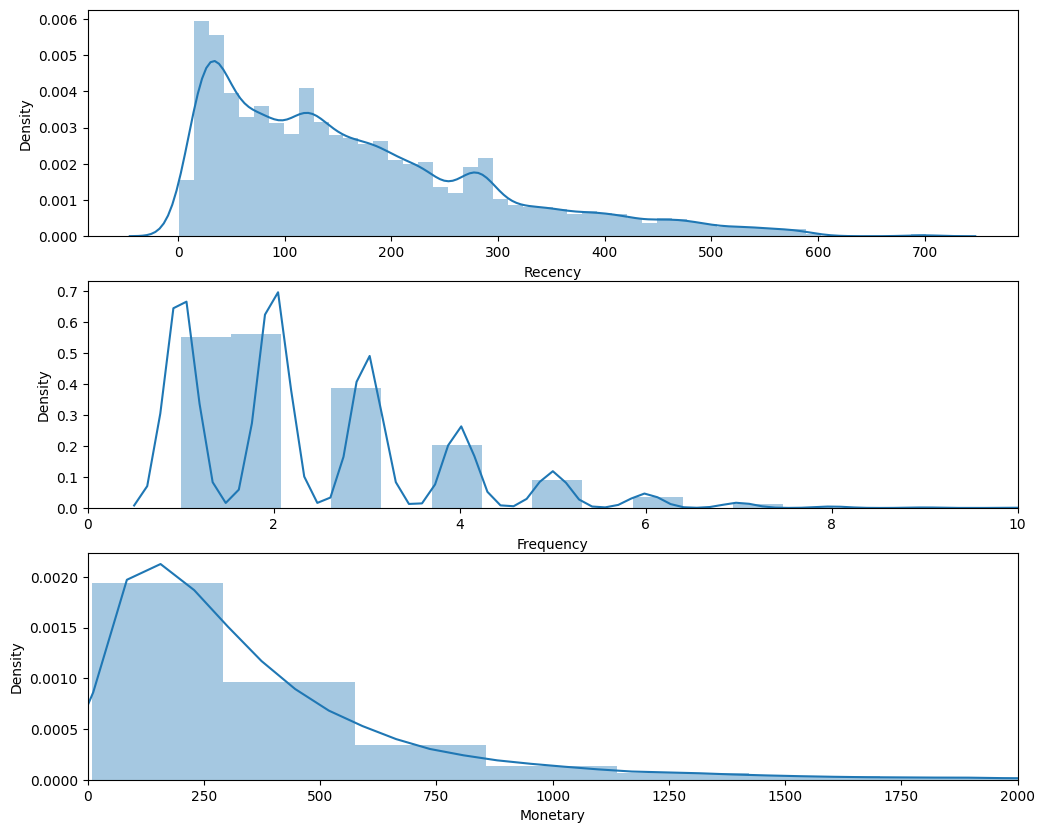

In [38]:
plt.figure(figsize=(12,10))
# Plot distribution of Recency
plt.subplot(3,1,1)
sns.distplot(data_process['Recency'])
# Plot distribution of Frequency
plt.subplot(3, 1, 2)
sns.distplot(data_process['Frequency'] )
plt.xlim(0,10)
# Plot distribution of Monetary
plt.subplot(3, 1, 3)
sns.distplot(data_process['Monetary'])
plt.xlim(0,2000)
# Show the plot
plt.show()

In [39]:
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 4)
# Assign these labels to 4 equal percentile groups 
# recency label càng lớn -> giá trị data_process['Recency'] càng nhỏ -> thời gian mua cuối cùng càng gần với hiện tại
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels, duplicates='drop')
# # Create new columns R and F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()

,Recency,Frequency,Monetary,R,F
customer_unique_id,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,175,2,136.26,2,1
0000f46a3911fa3c0805444483337064,131,3,583.87,3,2
0004bd2a26a76fe21f786e4fbd80607f,13,4,480.54,4,3
00050ab1314c0e55a6ca13cf7181fecf,225,1,80.18,2,1
0005ef4cd20d2893f0d9fbd94d3c0d97,487,1,187.91,1,1


In [41]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['Monetary'], q=4, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)
data_process.reset_index()
data_process

,Recency,Frequency,Monetary,R,F,M
customer_unique_id,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,175,2,136.26,2,1,1
0000f46a3911fa3c0805444483337064,131,3,583.87,3,2,4
0004bd2a26a76fe21f786e4fbd80607f,13,4,480.54,4,3,4
00050ab1314c0e55a6ca13cf7181fecf,225,1,80.18,2,1,1
0005ef4cd20d2893f0d9fbd94d3c0d97,487,1,187.91,1,1,2
...,...,...,...,...,...,...
fffa431dd3fcdefea4b1777d114144f2,168,3,1643.43,2,2,4
fffb09418989a0dbff854a28163e47c6,299,1,329.38,1,1,3
fffbf87b7a1a6fa8b03f081c5f51a201,57,2,199.50,4,1,2


with these 3 scores in place, R, F, and M, we can create our first RFM segment by concatenating the values together below

In [49]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): 
    return str(x['R']) + str(x['F']) + str(x['M'])
data_process['RFM_Segment'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,175,2,136.26,2,1,1,211,4
0000f46a3911fa3c0805444483337064,131,3,583.87,3,2,4,324,9
0004bd2a26a76fe21f786e4fbd80607f,13,4,480.54,4,3,4,434,11
00050ab1314c0e55a6ca13cf7181fecf,225,1,80.18,2,1,1,211,4
0005ef4cd20d2893f0d9fbd94d3c0d97,487,1,187.91,1,1,2,112,4


In [43]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment')['RFM_Segment'].nunique()
print(rfm_count_unique.sum())

48


In [44]:
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis =1 )
print(rfm['RFM_Score'].head())

customer_unique_id
0000b849f77a49e4a4ce2b2a4ca5be3f     4
0000f46a3911fa3c0805444483337064     9
0004bd2a26a76fe21f786e4fbd80607f    11
00050ab1314c0e55a6ca13cf7181fecf     4
0005ef4cd20d2893f0d9fbd94d3c0d97     4
Name: RFM_Score, dtype: int64


### Segmentation using RFM Analysis | Identify Upselling and Cross selling opportunities

+ Upselling là bổ sung vào giao dịch mua bằng cách bán cho khách hàng tiềm năng một phiên bản nâng cấp hoặc cải tiến của sản phẩm gốc.
+ Cross selling là bán kèm thêm vào giao dịch thông qua việc bổ sung cho các sản phẩm mua ban đầu

In [45]:
# Define rfm_level function
def rfm_level(df):
    if (df['RFM_Segment'] >= 434 or (df['RFM_Score'] >= 9)) :
        return 'VVIP - Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['M'] == 4)):
        return 'Champions Big Spenders'
    elif ((df['RFM_Score'] >= 6) and (df['F'] >= 2)):
        return 'Loyal Customers'
    elif ((df['RFM_Segment'] >= 221) or (df['RFM_Score'] >= 6)):
        return 'Potential Loyalists'
    elif (((df['RFM_Segment'] >= 121) and (df['R'] == 1)) or df['RFM_Score'] == 5):
        return 'Needs Attention'
    elif ((df['RFM_Score'] >= 4) and (df['R'] == 1)):
        return 'Hibernating - Almost Lost'
    else:
        return 'Lost Customers'

In [46]:
# Define rfm_level function
def rfm_action(df):
    if (df['RFM_Segment'] >= 434 or (df['RFM_Score'] >= 9)) :
        #không có ưu đãi về giá, cung cấp các phiên bản giới hạn và chương trình khách hanggf thân thiết
        return 'No Price Incentives; Offer Limited edition and Loyality programs'
    elif ((df['RFM_Score'] >= 8) and (df['M'] == 4)):
        # hội richkid , upsell  các mặt hàng đắt tiền nhất
        return 'Upsell most expensive items'
    elif ((df['RFM_Score'] >= 6) and (df['F'] >= 2)):
        #chương trình khách hàng thân thiết
        return 'Loyality programs;Cross Sell'
    elif ((df['RFM_Segment'] >= 221) or (df['RFM_Score'] >= 6)):
        return 'Cross Sell Recommendations and Discount coupons'
    elif (((df['RFM_Segment'] >= 121) and (df['R'] == 1)) or df['RFM_Score'] == 5):
        return 'Price incentives and Limited time offer'
    elif ((df['RFM_Score'] >= 4) and (df['R'] == 1)):
        # tích cực ưu đãi giá
        return 'Aggressive price incentives'
    else:
        # :)))
        return 'Don\'t spend too much trying to re-acquire'

In [51]:
# Create a new variable RFM_Level
rfm['RFM_Segment'] = rfm.RFM_Segment.apply(lambda x: int(x))
rfm['Customer Segment'] = rfm.apply(rfm_level, axis=1)
# Create a new variable RFM_Level
rfm['Marketing Action'] = rfm.apply(rfm_action, axis=1)
rfm.head(5)

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Customer Segment,Marketing Action
customer_unique_id,,,,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,175,2,136.26,2,1,1,211,4,Lost Customers,Don't spend too much trying to re-acquire
0000f46a3911fa3c0805444483337064,131,3,583.87,3,2,4,324,9,VVIP - Can't Loose Them,No Price Incentives; Offer Limited edition and...
0004bd2a26a76fe21f786e4fbd80607f,13,4,480.54,4,3,4,434,11,VVIP - Can't Loose Them,No Price Incentives; Offer Limited edition and...
00050ab1314c0e55a6ca13cf7181fecf,225,1,80.18,2,1,1,211,4,Lost Customers,Don't spend too much trying to re-acquire
0005ef4cd20d2893f0d9fbd94d3c0d97,487,1,187.91,1,1,2,112,4,Hibernating - Almost Lost,Aggressive price incentives


### Group Customer by their Customer Segment

In [52]:
# Calculate average values for each Customer Segment, and return a size of each segment 
rfm_level_agg = rfm.groupby('Customer Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'],
    'Marketing Action': 'unique'
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                          Recency Frequency Monetary          
                             mean      mean     mean  count   
Customer Segment                                              
Champions Big Spenders      166.4       2.8    831.7   1528  \
Hibernating - Almost Lost   352.5       1.4    192.0   2509   
Lost Customers              303.8       1.2     79.4   6896   
Loyal Customers             153.8       3.2    325.5   5614   
Needs Attention             248.8       1.8    244.7   3750   
Potential Loyalists         107.2       1.7    281.9  11264   
VVIP - Can't Loose Them      66.7       4.1    727.8  10169   

                                                            Marketing Action  
                                                                      unique  
Customer Segment                                                              
Champions Big Spenders                         [Upsell most expensive items]  
Hibernating - Almost Lost                      [Aggre

In [53]:
rfm_level_ag = pd.DataFrame(rfm_level_agg)
rfm_level_ag = rfm_level_ag.reset_index()
rfm_level_ag

Customer Segment Recency Frequency Monetary          
                                mean      mean     mean  count   
0     Champions Big Spenders   166.4       2.8    831.7   1528  \
1  Hibernating - Almost Lost   352.5       1.4    192.0   2509   
2             Lost Customers   303.8       1.2     79.4   6896   
3            Loyal Customers   153.8       3.2    325.5   5614   
4            Needs Attention   248.8       1.8    244.7   3750   
5        Potential Loyalists   107.2       1.7    281.9  11264   
6    VVIP - Can't Loose Them    66.7       4.1    727.8  10169   

                                    Marketing Action  
                                              unique  
0                      [Upsell most expensive items]  
1                      [Aggressive price incentives]  
2        [Don't spend too much trying to re-acquire]  
3                     [Loyality programs;Cross Sell]  
4          [Price incentives and Limited time offer]  
5  [Cross Sell Recommendations and Discount coupons]  
6  [No Price Incentives; Offer Limited edition an...

From here, we can see that a sufficient percentage (~45%) of our customers are in the top tier RFM levels. Olist must be doing something right to be maintaining their loyalty!
The other 55% will need some work.


#### 1. Potential Loyalists — 
High potential to enter our loyal customer segments, why not throw in some freebies on their next purchase to show that you value them!
#### 2. Needs Attention — 
Showing promising signs with quantity and value of their purchase but it has been a while since they last bought sometime from you. Let’s target them with their wishlist items and a limited time offer discount.
#### 3. Hibernating Almost Lost —
Made some initial purchase but have not seen them since. Was it a bad customer experience? Or product-market fit? Let’s spend some resource build our brand awareness with them.
#### 4. Lost Customers	—
Poorest performers of our RFM model. They might have went with our competitors for now and will require a different activation strategy to win them back.

In [54]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count', 'MarketingAction']
rfm_level_agg



,RecencyMean,FrequencyMean,MonetaryMean,Count,MarketingAction
Customer Segment,,,,,
Champions Big Spenders,166.4,2.8,831.7,1528,[Upsell most expensive items]
Hibernating - Almost Lost,352.5,1.4,192.0,2509,[Aggressive price incentives]
Lost Customers,303.8,1.2,79.4,6896,[Don't spend too much trying to re-acquire]
Loyal Customers,153.8,3.2,325.5,5614,[Loyality programs;Cross Sell]
Needs Attention,248.8,1.8,244.7,3750,[Price incentives and Limited time offer]
Potential Loyalists,107.2,1.7,281.9,11264,[Cross Sell Recommendations and Discount coupons]
VVIP - Can't Loose Them,66.7,4.1,727.8,10169,[No Price Incentives; Offer Limited edition an...


In [55]:
print(plt.get_fignums())

[]


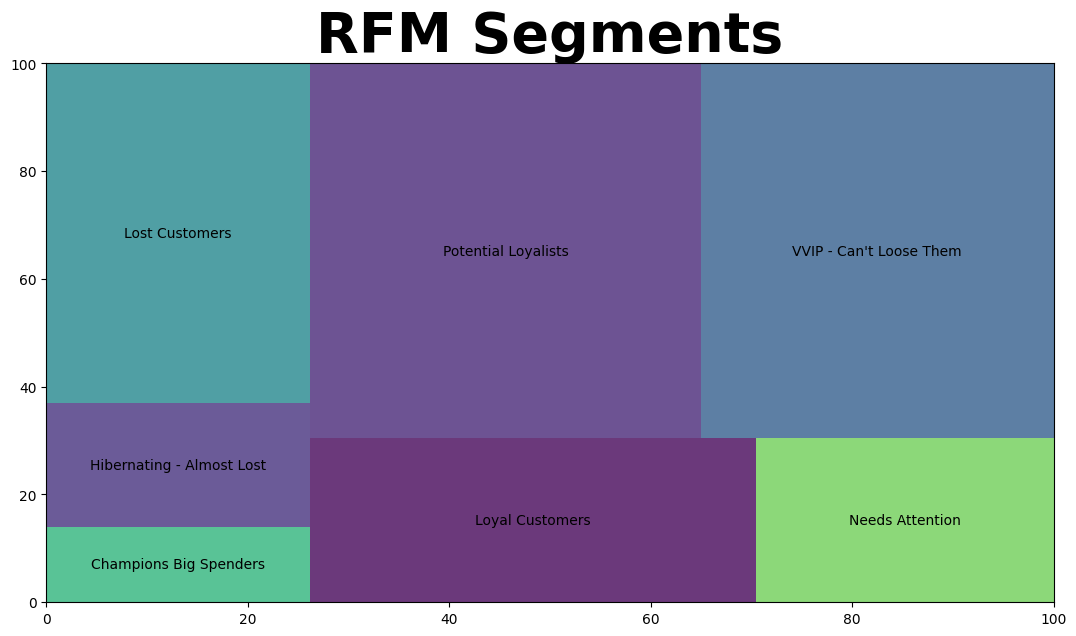

In [56]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13, 7)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Champions Big Spenders',
                     'Hibernating - Almost Lost',
                     'Lost Customers',
                     'Loyal Customers',
                     'Needs Attention',
                     'Potential Loyalists',
                     'VVIP - Can\'t Loose Them'], alpha=.8 )
plt.title("RFM Segments",fontsize=40,fontweight="bold")
plt.axis('on')
plt.show()

### Interactive Chart for Visualising Customer Segments

In [57]:
import plotly.graph_objects as go

fig =go.Figure(go.Treemap(
    labels = rfm_level_ag['Customer Segment'],
    parents = ['Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation'],   #rfm_level_ag[('Marketing Action', 'unique')].tolist(), 
    values= rfm_level_ag[('Monetary', 'count')]
), layout= go.Layout(title='Customer Segmentation'))

fig.show()

We can form our Marketing campaigns and targeting Strategies based on the above Customer Segmentation. 

- We can Upsell high end products to Big Spenders
- We can Cross Sell complimentary products to Loyal and Best Customers

### K-Means Clustering

We have carefully crafted the clusters based on the RFM score and segmented customers. Now lets apply a Machine Learning approach to identify if there are any hidden segments we can find from clusters.

In [59]:
rfm.head(5)


,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Customer Segment,Marketing Action
customer_unique_id,,,,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,175,2,136.26,2,1,1,211,4,Lost Customers,Don't spend too much trying to re-acquire
0000f46a3911fa3c0805444483337064,131,3,583.87,3,2,4,324,9,VVIP - Can't Loose Them,No Price Incentives; Offer Limited edition and...
0004bd2a26a76fe21f786e4fbd80607f,13,4,480.54,4,3,4,434,11,VVIP - Can't Loose Them,No Price Incentives; Offer Limited edition and...
00050ab1314c0e55a6ca13cf7181fecf,225,1,80.18,2,1,1,211,4,Lost Customers,Don't spend too much trying to re-acquire
0005ef4cd20d2893f0d9fbd94d3c0d97,487,1,187.91,1,1,2,112,4,Hibernating - Almost Lost,Aggressive price incentives


In [60]:
data_rfm = rfm[['Recency', 'Frequency', 'Monetary']]
data_rfm.head(5)

,Recency,Frequency,Monetary
customer_unique_id,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,175,2,136.26
0000f46a3911fa3c0805444483337064,131,3,583.87
0004bd2a26a76fe21f786e4fbd80607f,13,4,480.54
00050ab1314c0e55a6ca13cf7181fecf,225,1,80.18
0005ef4cd20d2893f0d9fbd94d3c0d97,487,1,187.91


In [61]:
import numpy as np
from sklearn.preprocessing import StandardScaler
data_log = np.log(data_rfm)
scaler = StandardScaler()
scaler.fit(data_log)
data_normalized = scaler.transform(data_log)
data_normalized = pd.DataFrame(data=data_normalized, index=data_rfm.index, columns=data_rfm.columns)
print(data_normalized.min())
print(data_normalized.max())

Recency     -4.987779
Frequency   -1.298726
Monetary    -3.543620
dtype: float64
Recency      1.907644
Frequency    4.642523
Monetary     4.383032
dtype: float64


In [62]:
from sklearn.cluster import KMeans
#unsupervised Learning
# demo nếu phân thành 5 cụm
kmeans = KMeans(n_clusters=5, random_state=1) 
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_
data_rfm_k5 = data_rfm.assign(Cluster=cluster_labels) # gán từng hàng với label đã xác định được nhờ KMeans  tương ứng


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



To find which ‘k’ value is more suitable for our data we will use elbow method.
phương pháp khủy tay


#### giải thích 1 chút về phương pháp KMeans
ý tưởng là sử dụng khoảng cách giữa 1 điểm là điểm trung tâm của cụm với các điểm trong 1 cụm. 

để biểu thị cho sự chính xác của thuật toán có thể tínht oán giá trị SSE. SSE là tổng của bình phương khoảng cách giữa mỗi điểm dữ liệu và tâm cụm tương ứng của nó. Mục tiêu của thuật toán K-means là tìm cách phân chia dữ liệu sao cho giá trị SSE là nhỏ nhất có thể, tức là các điểm dữ liệu gần nhau trong cùng một cụm và xa nhau giữa các cụm khác nhau.

#### Tìm cách phân cụm tốt nhất


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

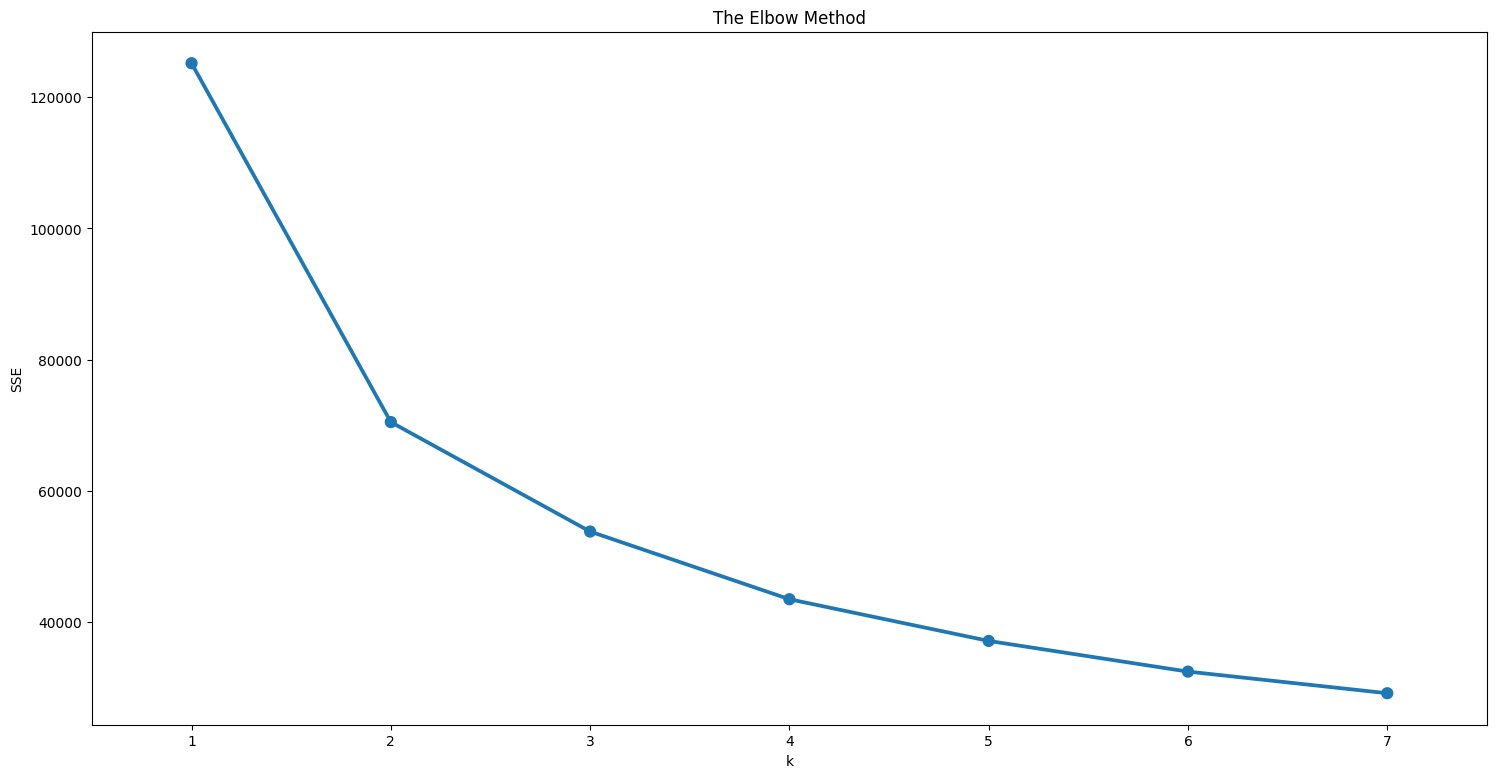

In [63]:
sse = {}
for k in range(1, 8):  
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_
plt.figure(figsize=(18,9))

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

ta thấy số cụm tốt nhất là số cụm ở đó sự thay đổi bắt đầu không đáng kể (đường thẳng nằm ngang hơn)
=> chọn n_clusters=  4

In [65]:
kmeans = KMeans(n_clusters=4, random_state=1) 
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_
rfm_k4 = rfm.assign(Cluster=cluster_labels)
grouped = rfm_k4.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0         202.2       2.5    381.9  14675
1          66.6       4.2    759.1   9717
2         276.3       1.1    116.1  11034
3          40.0       1.9    215.5   6304

In [68]:
rfm_k4.head(5)


,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Customer Segment,Marketing Action,Cluster
customer_unique_id,,,,,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,175,2,136.26,2,1,1,211,4,Lost Customers,Don't spend too much trying to re-acquire,0
0000f46a3911fa3c0805444483337064,131,3,583.87,3,2,4,324,9,VVIP - Can't Loose Them,No Price Incentives; Offer Limited edition and...,0
0004bd2a26a76fe21f786e4fbd80607f,13,4,480.54,4,3,4,434,11,VVIP - Can't Loose Them,No Price Incentives; Offer Limited edition and...,1
00050ab1314c0e55a6ca13cf7181fecf,225,1,80.18,2,1,1,211,4,Lost Customers,Don't spend too much trying to re-acquire,2
0005ef4cd20d2893f0d9fbd94d3c0d97,487,1,187.91,1,1,2,112,4,Hibernating - Almost Lost,Aggressive price incentives,2


In [69]:
rfm_k4_normalize = data_normalized.assign(Cluster = cluster_labels)

rfm_k4_normalize.head(5)

,Recency,Frequency,Monetary,Cluster
customer_unique_id,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,0.447298,-0.062860,-0.660136,0
0000f46a3911fa3c0805444483337064,0.142554,0.660076,0.920890,0
0004bd2a26a76fe21f786e4fbd80607f,-2.288597,1.173007,0.709269,1
00050ab1314c0e55a6ca13cf7181fecf,0.711765,-1.298726,-1.236313,2
0005ef4cd20d2893f0d9fbd94d3c0d97,1.524338,-1.298726,-0.310927,2


In [70]:
data_melt = pd.melt(
                    rfm_k4_normalize.reset_index(),               
                    id_vars=['customer_unique_id', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'Monetary'], 
                    var_name='Metric', value_name='Value' 
# giá trị của metric là tên cột và Value là giá trị của tên cột đó 
                    )
data_melt.head(10)

,customer_unique_id,Cluster,Metric,Value
0,0000b849f77a49e4a4ce2b2a4ca5be3f,0,Recency,0.447298
1,0000f46a3911fa3c0805444483337064,0,Recency,0.142554
2,0004bd2a26a76fe21f786e4fbd80607f,1,Recency,-2.288597
3,00050ab1314c0e55a6ca13cf7181fecf,2,Recency,0.711765
4,0005ef4cd20d2893f0d9fbd94d3c0d97,2,Recency,1.524338
5,000949456b182f53c18b68d6babc79c1,2,Recency,-0.031783
6,000a5ad9c4601d2bbdd9ed765d5213b3,0,Recency,0.435202
7,000c8bdb58a29e7115cfc257230fb21b,0,Recency,0.744005
8,000de6019bb59f34c099a907c151d855,3,Recency,-1.444261
9,000ec5bff359e1c0ad76a81a45cb598f,1,Recency,-0.714839


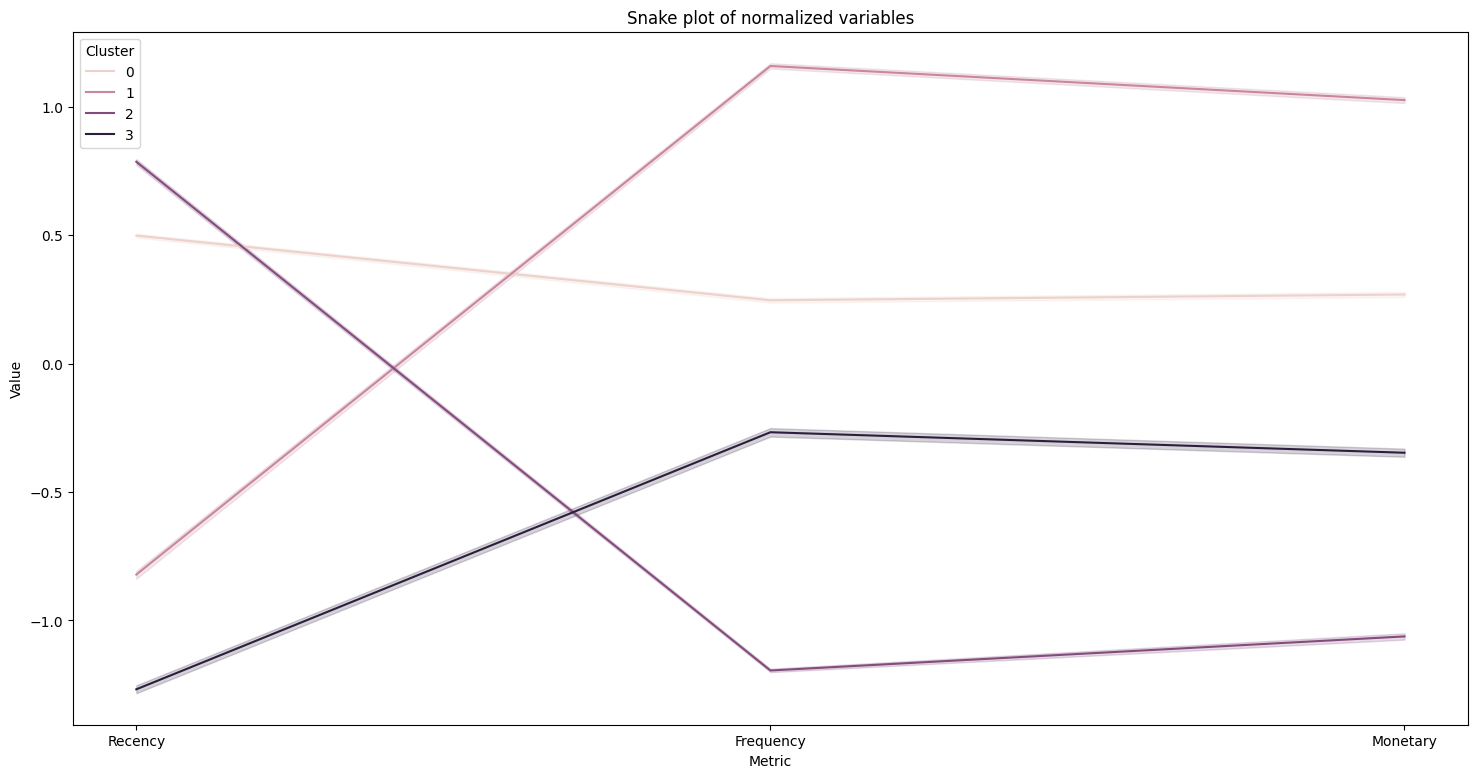

In [71]:

# Snake Plot
plt.figure(figsize = (18,9))
plt.title('Snake plot of normalized variables')
# plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data=data_melt, x='Metric', y='Value', hue='Cluster', )
plt.show()

### Calculate relative importance of each attribute
Now we will calculate the relative importance of the RFM values within each cluster.

In [72]:
cluster_avg = rfm_k4.groupby(['Cluster']).agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary':'mean'})
population_avg = data_rfm.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,0.22,0.03,0.02
1,-0.60,0.71,1.03
2,0.67,-0.55,-0.69
3,-0.76,-0.21,-0.42


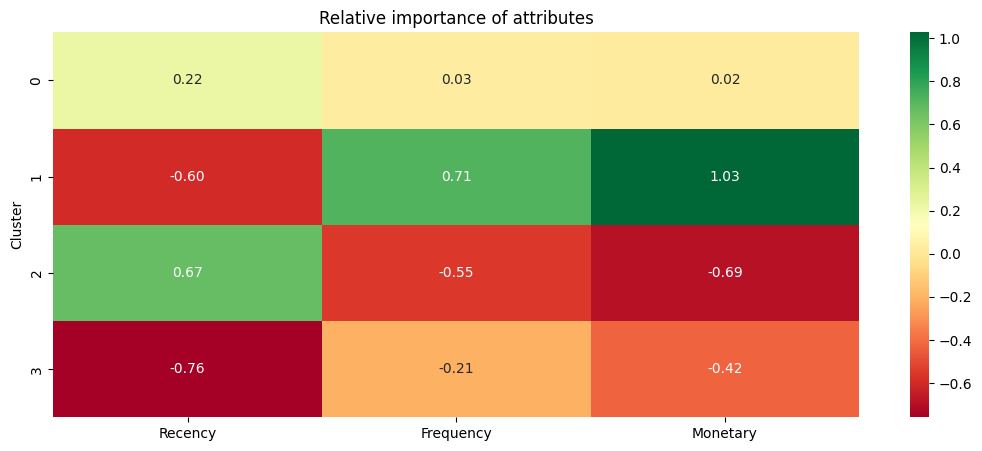

In [73]:
plt.figure(figsize=(13, 5))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

## Conclusion
### Relative Importance of RFM among K-Means Clusters

We can see that our grouped summary of the mean of R, F, M that each cluster of customers places a different emphasis on our 4 features:

#### Cluster 1
It has the highest MontaryValue mean and low Recency mean and the highest frequency mean — This is our ideal customer segment

#### Cluster 2
It performs poorly across R, F, and M. we will need to design campaigns to activate them again.

#### Cluster 3
They shopped with us recently but have not spend as much or as frequently as we would like them to — perhaps some personalization of products targeted at them can help to maximize their lifetime-value and come back to purchase?

#### Cluster 0
It has spent quite a fair amount with us but has not shopped with us in the 3–4 months — We will need to do something before we lose them!